### Planted neural network

In [1]:
%matplotlib notebook
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
matplotlib.style.use("rotskoff")

In [2]:
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

In [29]:
class CloneNet(nn.Module):
    def __init__(self, n_dim, n_hid, n_out, alpha=0.01, dtype=torch.float):
        super(CloneNet, self).__init__()
        self.lin1 = nn.Linear(n_dim, n_hid, bias=False)
        self.lin2 = nn.Linear(n_hid, n_out, bias=False)
        self.n_dim = n_dim
        self.n_hid = n_hid
        self.n_out = n_out
        self.alpha = alpha
        self.dtype = dtype

    def forward(self, x):
        h_out = F.relu(self.lin1(x.view(-1, self.n_dim)))
        return self.lin2(h_out)

    def get_rates(self):
        acU = self.alpha * self.lin2.weight * self.lin2.weight.grad
        return acU.flatten()

    def birth_death(self):
        rates = self.get_rates()
        
        np = rates.shape[0] # number of particles
        # kill particles
        kill_mask = (rates > 0.) * \
            (torch.rand(rates.shape, dtype=self.dtype) < torch.abs(rates))
        kill_vec = kill_mask.clone().float().unsqueeze(dim=1)
        n_kill = torch.sum(kill_mask)
        if n_kill > 0:
            # keep the survivors
            self.lin1.weight.data = (1 - kill_vec) * self.lin1.weight.data
            # resample the rows of lin1 where acU >= 0
            survivor_inds = torch.arange(0, np)[1 - kill_mask]
            # random survivor indices
            clone_inds = survivor_inds[torch.randint(survivor_inds.shape[0], (np,)).long()]
            # replace killed particles with random survivors
            self.lin1.weight.data += kill_vec * self.lin1.weight.data[clone_inds, :]
            # replace the corresponding weights or "charges"
            self.lin2.weight.data = self.lin2.weight.data * (1 - kill_vec.t()) + \
                kill_vec.t() * self.lin2.weight.data[:, clone_inds]
            print("Killed {:d} particles".format(n_kill),end="\r")
        
        clone_mask = (rates < 0.) * \
            (torch.rand(rates.shape, dtype=self.dtype) < torch.abs(rates))
        clone_vec = torch.tensor(clone_mask.unsqueeze(dim=1), dtype=self.dtype)
        n_clone = torch.sum(clone_mask)
        if n_clone > 0:
            # get the indices of the particles to clone
            clones = torch.arange(0, np)[clone_mask]
            # select random indices from the non-cloned particles
            non_clones = torch.arange(0, np)[1-clone_mask]
            replace_inds = non_clones[torch.randint(np-n_clone, (n_clone,)).long()]
            # replace the particles in replace inds with the clones
            self.lin1.weight.data[replace_inds, :] = self.lin1.weight.data[clones, :]
            self.lin2.weight.data[:, replace_inds] = self.lin2.weight.data[:, clones]
            print("Cloned {:d} particles".format(n_clone), end="\r")
                   

    def birth_death_with_prior(self):
        rates = self.get_rates()
        kill_mask = (rates > 0.) * \
            (torch.rand(rates.shape, dtype=self.dtype) < rates)

        n_kill = torch.sum(kill_mask)
        if n_kill > 0:
            kill_vec = torch.tensor(
                kill_mask.unsqueeze(dim=1), dtype=self.dtype)

            # resample the rows of lin1 where acU > 0
            self.lin1.weight.data = (1 - kill_vec) * self.lin1.weight.data + kill_vec * \
                self.rho_y(self.lin1.weight.shape)
            self.lin2.weight.data = self.lin2.weight.data * (1 - kill_vec.t())

            if n_kill > 0:
                print("Killed {:d} particles".format(n_kill), end="\r")

    def rho_y(self, shape):
        return torch.randn(shape, dtype=self.dtype) / self.n_hid

In [30]:
n_dim = 50
n_hid = 10
n_out = 1
teacher_net = CloneNet(n_dim, n_hid, n_out)
torch.nn.init.normal_(teacher_net.lin1.weight)
norms = torch.norm(teacher_net.lin1.weight.data, dim=1) * torch.abs(teacher_net.lin2.weight.data)
teacher_net.lin1.weight.data = (teacher_net.lin1.weight.data.t() / norms).t()

<IPython.core.display.Javascript object>


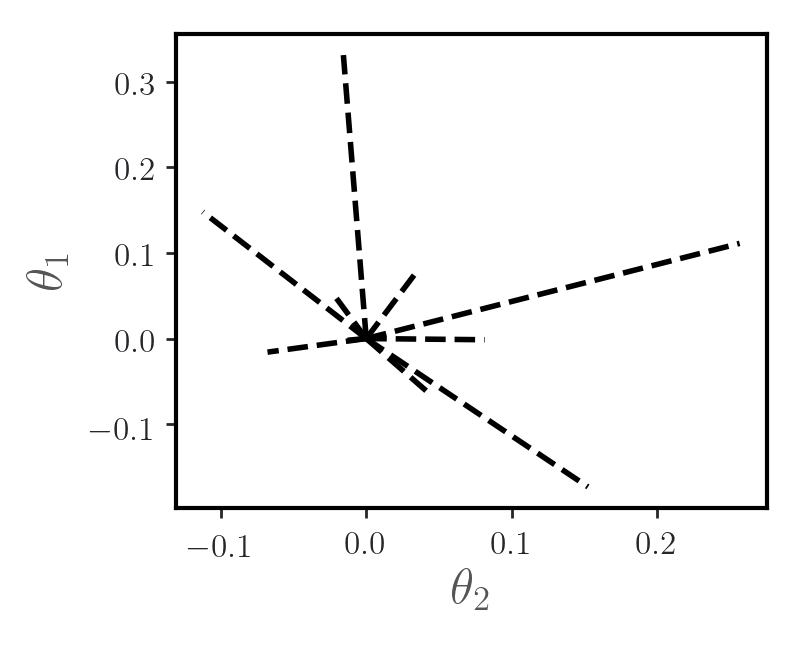

In [31]:
vs = (teacher_net.lin1.weight.data.t() * torch.abs(teacher_net.lin2.weight.data)).t()
vs = vs.numpy()
fig, ax = plt.subplots()

xs = np.linspace(0,1,100)
ax.set_ylabel(r"$\theta_1$", fontsize=18)
ax.set_xlabel(r"$\theta_2$", fontsize=18)
for i in range(len(vs)):
    ax.plot(xs*vs[i,0], xs*vs[i,1], "--", color="k")

In [41]:
n = 50
student_net = CloneNet(n_dim, n, n_out)
torch.nn.init.normal_(student_net.lin1.weight, std=1./np.sqrt(n))

Parameter containing:
tensor([[ 0.2330,  0.0736, -0.1324,  ...,  0.0364,  0.3067, -0.1516],
        [ 0.2713, -0.1029,  0.1727,  ..., -0.0477, -0.0103, -0.0931],
        [ 0.1655, -0.1410, -0.1204,  ...,  0.1044, -0.1098,  0.0255],
        ...,
        [ 0.1765, -0.2023,  0.1627,  ...,  0.1105, -0.0085, -0.0309],
        [-0.0597, -0.0706,  0.2468,  ...,  0.2934,  0.0283, -0.1292],
        [ 0.0056,  0.0634,  0.1155,  ..., -0.0742,  0.0628,  0.0378]],
       requires_grad=True)

In [49]:
# set the shared training parameters
learning_rate = 2e-2
n_steps = 100000
n_batch = 100
stride = 50
criterion = torch.nn.MSELoss()

In [50]:
optimizer = optim.SGD(student_net.parameters(), lr=learning_rate)

traj_shape = list((n_steps//stride,*tuple(student_net.lin1.weight.shape)))
traj_shape = tuple(traj_shape)
student_traj = torch.zeros(traj_shape)
#for epoch in range(100):  # loop over the dataset multiple times
loss_data = np.zeros(n_steps)

#gaussian_data = torch.randn(n_batch, n_dim, dtype=torch.float)
#inputs =  gaussian_data /  torch.norm(gaussian_data, dim=0)

for i in range(n_steps):

    # zero the parameter gradient
    optimizer.zero_grad()
    gaussian_data = torch.randn(n_batch, n_dim, dtype=torch.float)
    inputs =  gaussian_data / torch.norm(gaussian_data, dim=1).unsqueeze(1)


    student_outputs = student_net(inputs)
    teacher_outputs = teacher_net(inputs)

    loss = criterion(student_outputs, teacher_outputs)
    loss.backward()
    optimizer.step()
    loss_data[i] = loss.data

    if (i%stride==0):
        thetai = torch.abs(student_net.lin2.weight.data.t()) * student_net.lin1.weight.data
        student_traj[i//stride] = thetai

print('Finished Training')

Finished Training


<IPython.core.display.Javascript object>


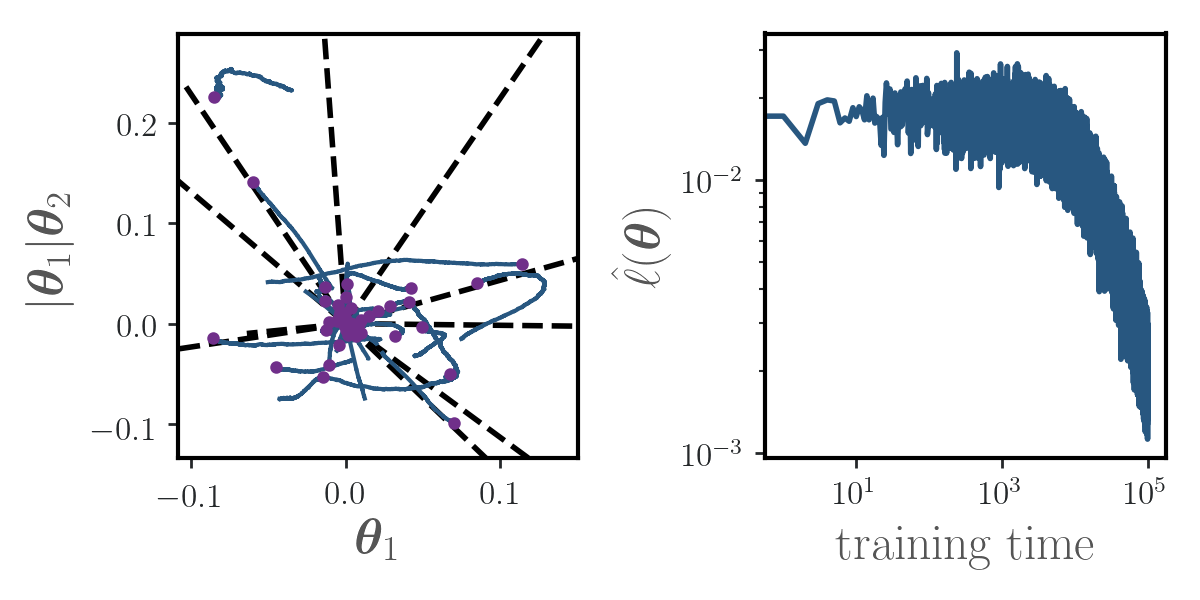

In [51]:
vs = (teacher_net.lin1.weight.data.t() * torch.abs(teacher_net.lin2.weight.data)).t()
vs = vs.numpy()
fig1, [ax1,ax2] = plt.subplots(1,2,figsize=(6,3))
#ax.set_xlim(-0.1,0.1)
#ax.set_ylim(-0.1,0.1)
xs = np.linspace(0,5,100)
ax1.set_ylabel(r"$|\boldsymbol{\theta}_1|\boldsymbol{\theta}_2$", fontsize=18)
ax1.set_xlabel(r"$\boldsymbol{\theta}_1$", fontsize=18)


for i in range(len(vs)):
    ax1.plot(xs*vs[i,0], xs*vs[i,1], "--", color="k")
    
for i in range(student_traj.shape[1]):
    ax1.plot(student_traj[:,i,0].numpy(), student_traj[:,i,1].numpy(), color=colors[0], lw=1.5)
    
for i in range(student_traj.shape[1]):
    ax1.plot(student_traj[-1,i,0].numpy(), student_traj[-1,i,1].numpy(), "o", markersize=3.5, color=colors[3])
    

xmin = torch.min(student_traj[:,:,0]).numpy()
ymin = torch.min(student_traj[:,:,1]).numpy()    
xmax = torch.max(student_traj[:,:,0]).numpy()
ymax = torch.max(student_traj[:,:,1]).numpy()
dx = xmax-xmin
dy = ymax-ymin
ax1.set_xlim(xmin-0.1*dx,xmax + 0.1*dx)
ax1.set_ylim(ymin-0.1*dy,ymax+0.1*dy)
    
with torch.no_grad():
    ax2.loglog(loss_data)
    ax2.set_ylabel(r"$\hat{\ell}(\boldsymbol{\theta})$")
    ax2.set_xlabel(r"$\textrm{training time}$")
    
fig1.savefig("gd_traj.pdf")

In [52]:
clone_net = CloneNet(n_dim, n, n_out, alpha=1.)
torch.nn.init.normal_(clone_net.lin1.weight, std=1./np.sqrt(n))

Parameter containing:
tensor([[-0.1082,  0.0479, -0.0940,  ..., -0.0161,  0.0762,  0.1125],
        [ 0.0142,  0.1082,  0.0354,  ...,  0.0994, -0.1020,  0.0831],
        [-0.0696, -0.1573, -0.0697,  ...,  0.0320, -0.0191,  0.0394],
        ...,
        [-0.0686, -0.0708,  0.0555,  ...,  0.0101,  0.0929,  0.2282],
        [-0.1336, -0.1342, -0.0847,  ...,  0.0638, -0.0411, -0.0526],
        [ 0.1318, -0.1381, -0.1187,  ...,  0.0333, -0.0749,  0.0037]],
       requires_grad=True)

In [53]:
#criterion = torch.nn.MSELoss()
optimizer = optim.SGD(clone_net.parameters(), lr=learning_rate)

traj_shape = list((n_steps//stride,*tuple(clone_net.lin1.weight.shape)))
traj_shape = tuple(traj_shape)
clone_traj = torch.zeros(traj_shape)
clone_loss_data = np.zeros(n_steps)

for i in range(n_steps):

    # zero the parameter gradients

    optimizer.zero_grad()
    gaussian_data = torch.randn(n_batch,n_dim,dtype=torch.float)
    inputs =  gaussian_data / torch.norm(gaussian_data, dim=1).unsqueeze(1)

    clone_outs = clone_net(inputs)
    teacher_outs = teacher_net(inputs)

    loss = criterion(clone_outs, teacher_outs)
    loss.backward()
    optimizer.step()
    clone_loss_data[i] = loss.data
    
    with torch.no_grad():
        #if i<(n_steps - n_steps//5):
        clone_net.birth_death()

        if (i%stride==0):
            thetai = torch.abs(clone_net.lin2.weight.data.t()) * clone_net.lin1.weight.data
            clone_traj[i//stride] = thetai

print('Finished Training')

/home/grant/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Finished Trainings


<IPython.core.display.Javascript object>


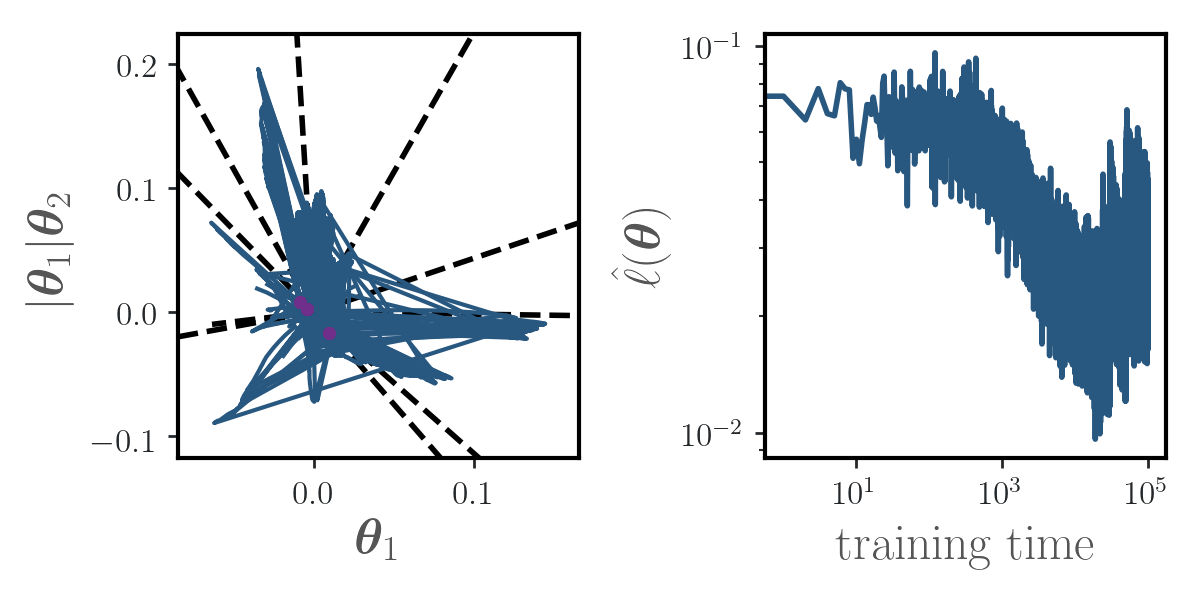

In [54]:
fig2, [ax1,ax2] = plt.subplots(1,2,figsize=(6,3))
xs = np.linspace(0,5,100)
ax1.set_ylabel(r"$|\boldsymbol{\theta}_1|\boldsymbol{\theta}_2$", fontsize=18)
ax1.set_xlabel(r"$\boldsymbol{\theta}_1$", fontsize=18)


for i in range(len(vs)):
    ax1.plot(xs*vs[i,0], xs*vs[i,1], "--", color="k")
    
for i in range(student_traj.shape[1]):
    ax1.plot(clone_traj[:,i,0].numpy(), clone_traj[:,i,1].numpy(), color=colors[0], lw=1.5)
    
for i in range(student_traj.shape[1]):
    ax1.plot(clone_traj[-1,i,0].numpy(), clone_traj[-1,i,1].numpy(), "o", markersize=3.5, color=colors[3])

    
xmin = torch.min(clone_traj[:,:,0]).numpy()
ymin = torch.min(clone_traj[:,:,1]).numpy()    
xmax = torch.max(clone_traj[:,:,0]).numpy()
ymax = torch.max(clone_traj[:,:,1]).numpy()
dx = xmax-xmin
dy = ymax-ymin
ax1.set_xlim(xmin-0.1*dx,xmax+0.1*dx)
ax1.set_ylim(ymin-0.1*dy,ymax+0.1*dy)
    
with torch.no_grad():
    ax2.loglog(clone_loss_data)
    ax2.set_ylabel(r"$\hat{\ell}(\boldsymbol{\theta})$")
    ax2.set_xlabel(r"$\textrm{training time}$")

fig2.savefig("bd_traj.pdf")

In [59]:
prior_net = CloneNet(n_dim, n, n_out, alpha=0.01)
torch.nn.init.normal_(prior_net.lin1.weight, std=1./np.sqrt(n))

Parameter containing:
tensor([[ 0.0317,  0.0491, -0.0076,  ...,  0.1655, -0.2210, -0.0188],
        [-0.0708,  0.4071,  0.0869,  ...,  0.0301, -0.0272,  0.2880],
        [-0.1022,  0.0071, -0.1069,  ...,  0.0125,  0.3751,  0.0648],
        ...,
        [-0.1578, -0.0352, -0.1566,  ..., -0.0099,  0.1943, -0.1013],
        [-0.0435,  0.0896,  0.0793,  ...,  0.2061, -0.0699,  0.0086],
        [-0.1809, -0.1076,  0.1947,  ..., -0.1743, -0.0399,  0.1788]],
       requires_grad=True)

In [60]:
#criterion = torch.nn.MSELoss()
optimizer = optim.SGD(prior_net.parameters(), lr=learning_rate)

traj_shape = list((n_steps//stride,*tuple(prior_net.lin1.weight.shape)))
traj_shape = tuple(traj_shape)
prior_traj = torch.zeros(traj_shape)
prior_loss_data = np.zeros(n_steps)

for i in range(n_steps):

    # zero the parameter gradients

    optimizer.zero_grad()
    gaussian_data = torch.randn(n_batch,n_dim,dtype=torch.float)
    inputs =  gaussian_data / torch.norm(gaussian_data, dim=1).unsqueeze(1)

    prior_outs = prior_net(inputs)
    teacher_outs = teacher_net(inputs)

    loss = criterion(prior_outs, teacher_outs)
    loss.backward()
    optimizer.step()
    prior_loss_data[i] = loss.data
    
    with torch.no_grad():
        #if i<(n_steps - n_steps//5):
        prior_net.birth_death_with_prior()

        if (i%stride==0):
            thetai = torch.abs(prior_net.lin2.weight.data.t()) * prior_net.lin1.weight.data
            prior_traj[i//stride] = thetai

print('Finished Training')

/home/grant/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Finished Trainings


<IPython.core.display.Javascript object>


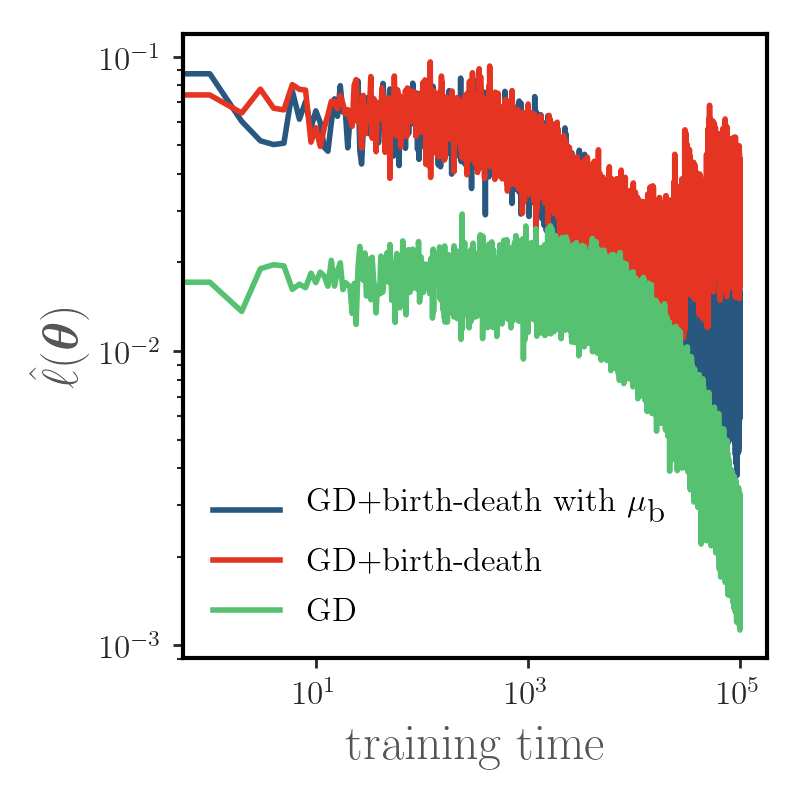

In [57]:
fig3, ax = plt.subplots(figsize=(4,4))
ax.loglog(prior_loss_data, label=r"$\textrm{GD+birth-death with }\mu_{\textrm{b}}$")
ax.loglog(clone_loss_data, label=r"$\textrm{GD+birth-death}$")
ax.loglog(loss_data, label=r"$\textrm{GD}$")
ax.set_ylabel(r"$\hat{\ell}(\boldsymbol{\theta})$")
ax.set_xlabel(r"$\textrm{training time}$")
ax.legend(fontsize=12)
fig3.savefig("planted_nn_loss_with_prior.pdf")

<IPython.core.display.Javascript object>


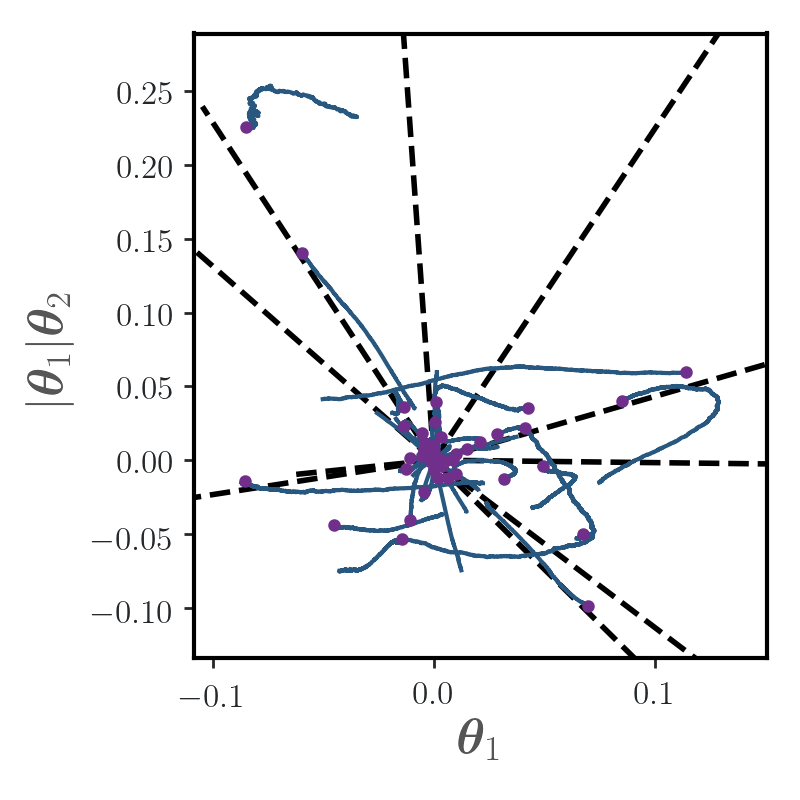

In [58]:
fig1, ax1 = plt.subplots(figsize=(4,4))
#ax.set_xlim(-0.1,0.1)
#ax.set_ylim(-0.1,0.1)
xs = np.linspace(0,5,100)
ax1.set_ylabel(r"$|\boldsymbol{\theta}_1|\boldsymbol{\theta}_2$", fontsize=18)
ax1.set_xlabel(r"$\boldsymbol{\theta}_1$", fontsize=18)


for i in range(len(vs)):
    ax1.plot(xs*vs[i,0], xs*vs[i,1], "--", color="k")
    
for i in range(student_traj.shape[1]):
    ax1.plot(student_traj[:,i,0].numpy(), student_traj[:,i,1].numpy(), color=colors[0], lw=1.5)
    
for i in range(student_traj.shape[1]):
    ax1.plot(student_traj[-1,i,0].numpy(), student_traj[-1,i,1].numpy(), "o", markersize=3.5, color=colors[3])
    

xmin = torch.min(student_traj[:,:,0]).numpy()
ymin = torch.min(student_traj[:,:,1]).numpy()    
xmax = torch.max(student_traj[:,:,0]).numpy()
ymax = torch.max(student_traj[:,:,1]).numpy()
dx = xmax-xmin
dy = ymax-ymin
ax1.set_xlim(xmin-0.1*dx,xmax + 0.1*dx)
ax1.set_ylim(ymin-0.1*dy,ymax+0.1*dy)
    
fig1.savefig("nn_gd_projection.pdf")